In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = '172.30.248.86'
mysql_port = '3306'
mysql_username = 'mms'
mysql_password = 'agedb'
mysql_dbname = 'aoe2de'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*COLSAN*/
SELECT
    matches.version,
    matches.server,
    matches.duration_minutes AS 'duration',
    players.rating,
    players.color,
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    players.profile_id = '369046';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(144, 7)

In [4]:
df.head(10)

,version,server,duration,rating,color,civ,won
0,39284,ukwest,37,NaN,red,Khmer,0
1,39284,westeurope,27,885.0,red,Goths,1
2,39284,ukwest,33,860.0,blue,Japanese,1
3,39515,ukwest,20,880.0,blue,Indians,1
4,39515,ukwest,31,881.0,blue,Portuguese,0
5,39515,ukwest,34,896.0,red,Celts,0
6,39515,ukwest,10,881.0,red,Mongols,1
7,39515,ukwest,39,883.0,blue,Portuguese,0
8,39515,ukwest,14,883.0,blue,Spanish,1
9,39515,ukwest,30,897.0,red,Turks,0


In [5]:
df.tail(10)

,version,server,duration,rating,color,civ,won
134,47820,ukwest,29,1013.0,red,Saracens,0
135,47820,ukwest,15,982.0,red,Turks,1
136,47820,ukwest,36,1014.0,red,Cumans,1
137,47820,ukwest,18,1001.0,blue,Magyars,1
138,47820,ukwest,15,1016.0,blue,Saracens,1
139,47820,ukwest,9,1032.0,blue,Persians,1
140,47820,ukwest,18,1047.0,red,Japanese,1
141,47820,ukwest,27,1048.0,red,Sicilians,0
142,47820,ukwest,28,1048.0,red,Berbers,1
143,47820,eastus,24,1064.0,blue,Persians,1


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

version     0
server      0
duration    0
rating      1
color       0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde la variable "rating" es NaN.
df.dropna(inplace=True)
df.shape

(143, 7)

In [8]:
# Poner la primera letra en mayúsculas.
df['color']   = df['color'].str.capitalize()
df['server'] = df['server'].str.capitalize()
# Convertir variable "rating" de float64 a int64.
df['rating'] = df['rating'].astype('int64')
df.head(10)

,version,server,duration,rating,color,civ,won
1,39284,Westeurope,27,885,Red,Goths,1
2,39284,Ukwest,33,860,Blue,Japanese,1
3,39515,Ukwest,20,880,Blue,Indians,1
4,39515,Ukwest,31,881,Blue,Portuguese,0
5,39515,Ukwest,34,896,Red,Celts,0
6,39515,Ukwest,10,881,Red,Mongols,1
7,39515,Ukwest,39,883,Blue,Portuguese,0
8,39515,Ukwest,14,883,Blue,Spanish,1
9,39515,Ukwest,30,897,Red,Turks,0
10,39515,Brazilsouth,31,881,Red,Berbers,0


In [9]:
# Convertir variables object a category.
df['version']   = df['version'].astype('category')
df['server']    = df['server'].astype('category')
df['color']      = df['color'].astype('category')
df['civ']           = df['civ'].astype('category')

In [10]:
# Comprobación de cada tipo de variable.
df.dtypes

version     category
server      category
duration       int64
rating         int64
color       category
civ         category
won            int64
dtype: object

In [11]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,rating,won
count,143.000000,143.000000,143.000000
mean,26.013986,999.734266,0.517483
std,10.652637,59.069540,0.501451
min,1.000000,848.000000,0.000000
25%,19.000000,963.000000,0.000000
50%,27.000000,1008.000000,1.000000
75%,32.000000,1043.000000,1.000000
max,67.000000,1105.000000,1.000000


<AxesSubplot:xlabel='rating', ylabel='Density'>

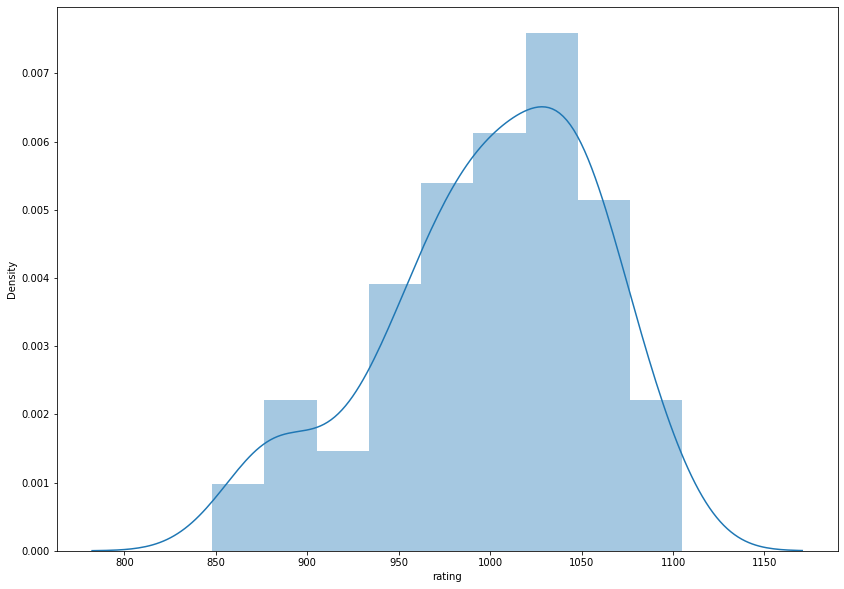

In [12]:
sns.distplot(df.rating)

<AxesSubplot:xlabel='rating'>

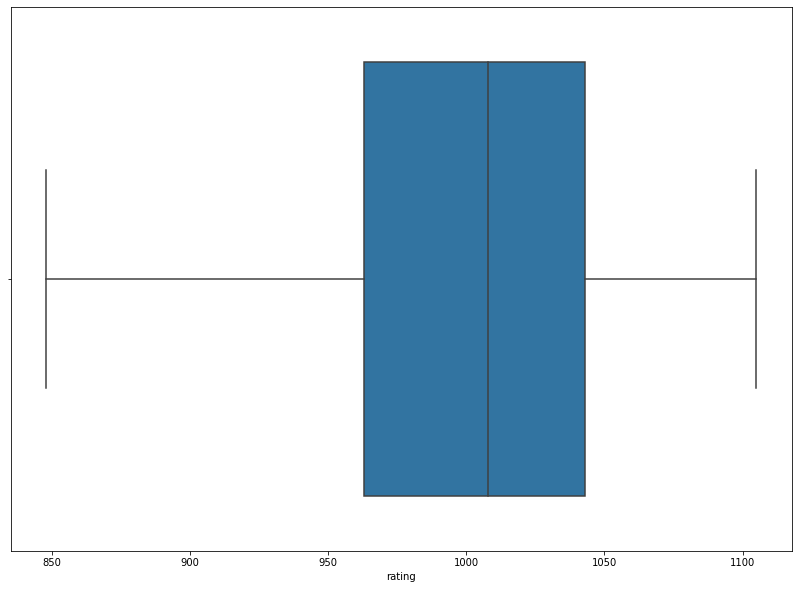

In [13]:
sns.boxplot(df.rating)

<AxesSubplot:xlabel='duration', ylabel='Density'>

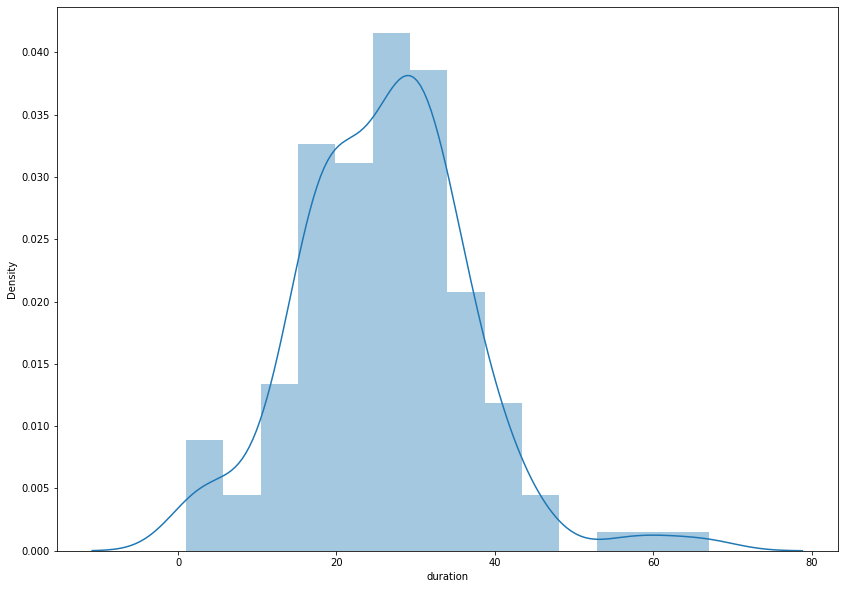

In [14]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

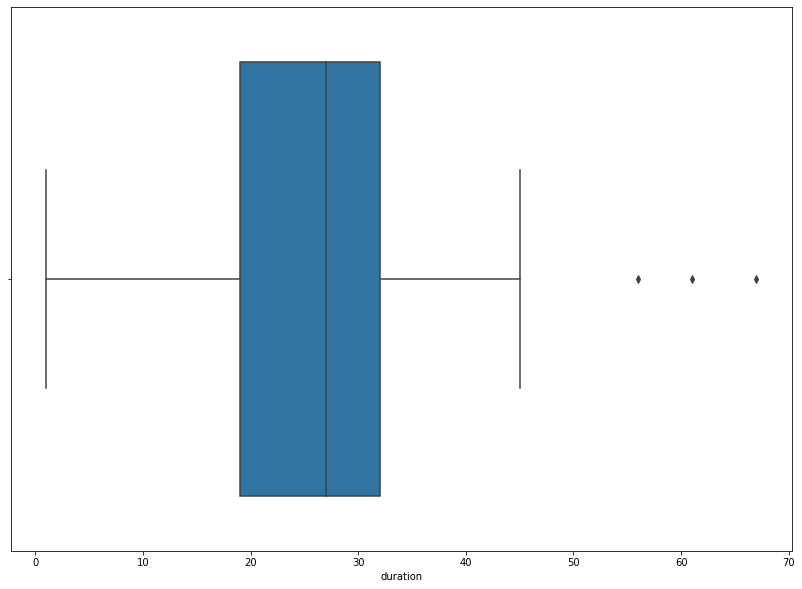

In [15]:
sns.boxplot(df.duration)

In [16]:
# Valores únicos de la variable "version".
versions = df.version.unique().tolist()
versions.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por versión".
def get_frequency_rates_by_version(df):
    return pd.DataFrame(df.version.value_counts(normalize=True)).reset_index().rename(columns={"index": "version", "version": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por versión".
def get_win_rates_by_version(df):
    return (
        df.groupby("version")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_version = get_frequency_rates_by_version(df)
win_rates_version              = get_win_rates_by_version(df)

Text(0.5, 1.0, 'Frecuencia de partidas por version')

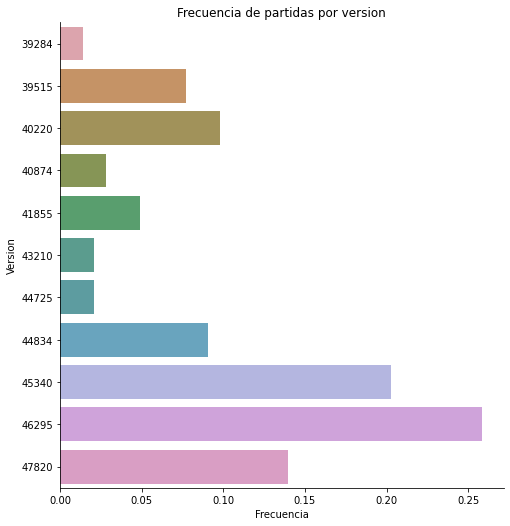

In [17]:
sns.catplot(y="version", x="frequency",  data=frequency_rates_version, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Version")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por version")

Text(0.5, 1.0, 'Tasa de victorias por versión')

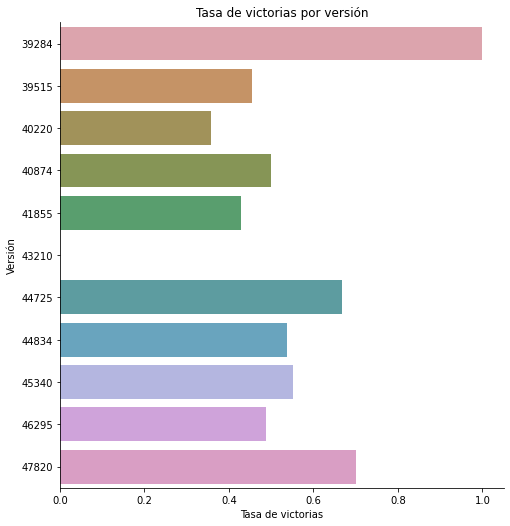

In [18]:
sns.catplot(y="version", x="win_rate",  data=win_rates_version, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Versión")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por versión")

In [19]:
# Valores únicos de la variable "server".
servers = df.server.unique().tolist()
servers.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por servidor".
def get_frequency_rates_by_server(df):
    return pd.DataFrame(df.server.value_counts(normalize=True)).reset_index().rename(columns={"index": "server", "server": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por servidor".
def get_win_rates_by_server(df):
    return (
        df.groupby("server")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_server = get_frequency_rates_by_server(df)
win_rates_server              = get_win_rates_by_server(df)

Text(0.5, 1.0, 'Frecuencia de partidas por servidor')

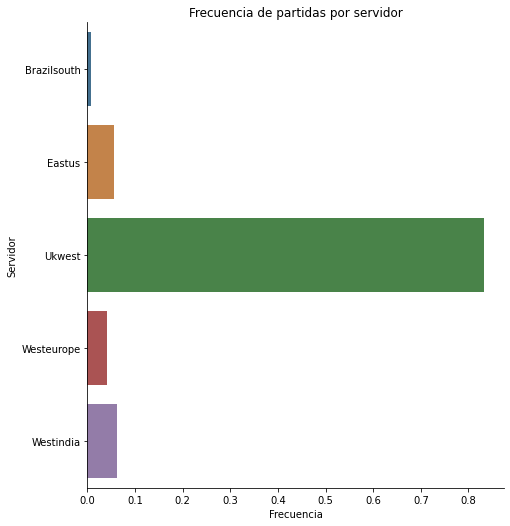

In [20]:
sns.catplot(y="server", x="frequency",  data=frequency_rates_server, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Servidor")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por servidor")

Text(0.5, 1.0, 'Tasa de victorias por servidor')

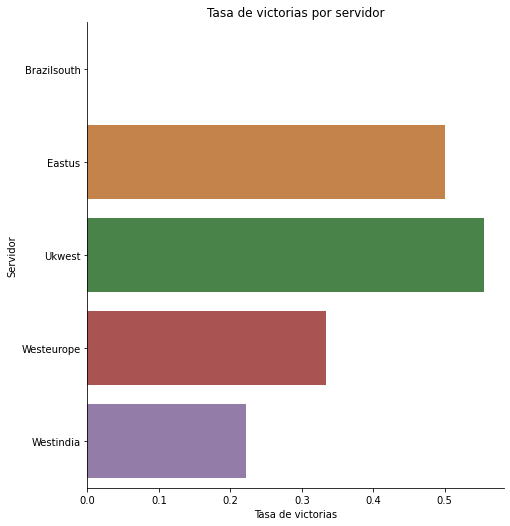

In [21]:
sns.catplot(y="server", x="win_rate",  data=win_rates_server, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Servidor")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por servidor")

In [22]:
# Valores únicos de la variable "color".
colors = df.color.unique().tolist()
colors.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_color(df):
    return pd.DataFrame(df.color.value_counts(normalize=True)).reset_index().rename(columns={"index": "color", "color": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_color(df):
    return (
        df.groupby("color")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_color = get_frequency_rates_by_color(df)
win_rates_color              = get_win_rates_by_color(df)

Text(0.5, 1.0, 'Frecuencia de partidas por color')

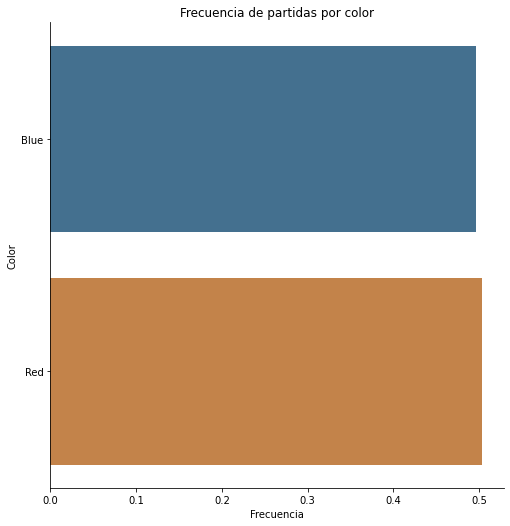

In [23]:
sns.catplot(y="color", x="frequency",  data=frequency_rates_color, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Color")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por color")

Text(0.5, 1.0, 'Tasa de victorias por color')

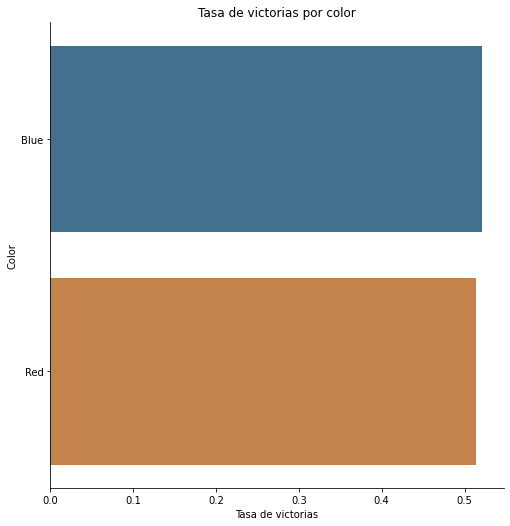

In [24]:
sns.catplot(y="color", x="win_rate",  data=win_rates_color, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Color")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por color")

In [25]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

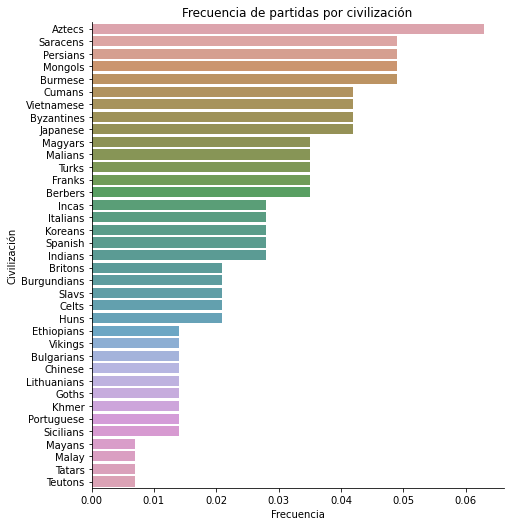

In [26]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

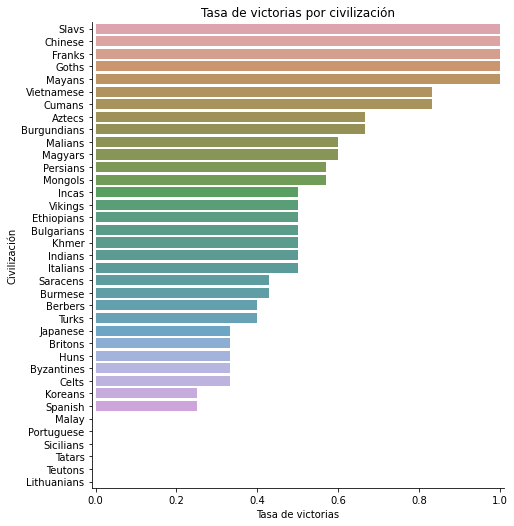

In [27]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [28]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["version", "server", "color", "civ"]
for category in categorical:
    df = create_dummies(df, category)

In [29]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,rating,won,version_39284,version_39515,version_40220,version_40874,version_41855,version_43210,version_44725,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
1,0.393939,0.143969,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.484848,0.046693,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.287879,0.124514,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.454545,0.128405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.500000,0.186770,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.121212,0.715953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0.257576,0.774319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0.393939,0.778210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,0.409091,0.778210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

-------------
Features: 4
         Current function value: 0.646063
         Iterations: 35
-------------
Features: 8
         Current function value: 0.522143
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.645459
         Iterations 5
-------------
Features: 12
         Current function value: 0.479952
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.638058
         Iterations 5
-------------
Features: 16
         Current function value: inf
         Iterations: 35
-------------
Features: 20
         Current function value: inf
         Iterations: 35
-------------
Features: 24
         Current function value: 0.390416
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.629658
         Iterations 5
-------------
Features: 28
         Current function value: inf
         Iterations: 35
-------------
Features: 32
         Current function value: 

In [31]:
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

,initial_features,final_features,aic,bic,df_residuals,r_squared,score_accuracy,roc_auc_score
0,32.0,5.0,188.0910,202.9053,138.0,0.1008,0.5814,0.5866
1,40.0,5.0,188.0910,202.9053,138.0,0.1008,0.5814,0.5866
2,24.0,4.0,188.0821,199.9334,139.0,0.0908,0.5581,0.5639
3,36.0,4.0,188.0821,199.9334,139.0,0.0908,0.5581,0.5639
4,12.0,3.0,188.4846,197.3731,140.0,0.0787,0.5581,0.5639
5,8.0,2.0,188.6013,194.5270,141.0,0.0680,0.5349,0.5433
6,56.0,2.0,197.8985,203.8242,141.0,0.0210,0.5349,0.5433


In [32]:
f = int(summary_models_logreg.initial_features[0])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

         Current function value: 0.368768
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.622696
         Iterations 5


In [33]:
logreg_sm_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.101     
Dependent Variable: won              AIC:              188.0910  
Date:               2021-07-02 16:08 BIC:              202.9053  
No. Observations:   143              Log-Likelihood:   -89.046   
Df Model:           4                LL-Null:          -99.033   
Df Residuals:       138              LLR p-value:      0.00050529
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
duration          -3.5643   1.0343 -3.4462 0.0006 -5.5915 -1.5372
version_47820      0.7811   0.5532  1.4118 0.1580 -0.3033  1.8654
server_Eastus      1.3048   0.8329  1.5665 0.1172 -0.3277  2.9372
server_Ukwest      1.5226   0.4508  3.3772 0.0007  0.6390  2.4063
civ_Japanese      -1.2524   0.9227 -1.3573 0.1747 -3.0610  0.5561
=================================================================

"""

In [34]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients

,Variable,Coeficiente
0,duration,-3.564322
1,version_47820,0.781051
2,server_Eastus,1.304756
3,server_Ukwest,1.522614
4,civ_Japanese,-1.252446


In [35]:
for index, row in coefficients.iterrows():
    print("Si la variable " + row["Variable"] + " incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

Si la variable duration incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en -3.564
Si la variable version_47820 incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.781
Si la variable server_Eastus incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.305
Si la variable server_Ukwest incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.523
Si la variable civ_Japanese incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en -1.252


In [36]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

,duration,version_47820,server_Eastus,server_Ukwest,civ_Japanese
duration,1.0,NaN,NaN,NaN,NaN
version_47820,NaN,1.0,NaN,NaN,NaN
server_Eastus,NaN,NaN,1.0,NaN,NaN
server_Ukwest,NaN,NaN,NaN,1.0,NaN
civ_Japanese,NaN,NaN,NaN,NaN,1.0


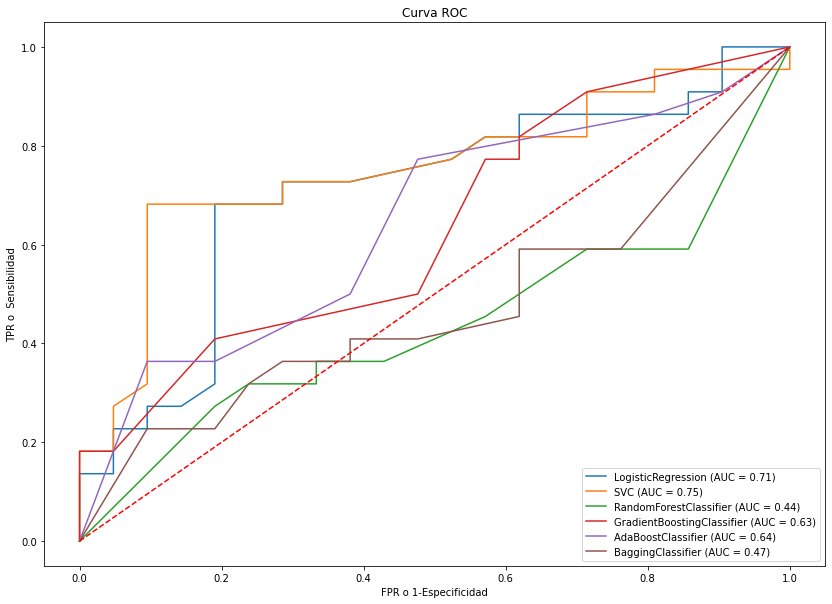

In [37]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [38]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

,Model,Score
0,LogisticRegression,0.62791
1,SVC (SupportVectorClassifier),0.60465
2,GradientBoostingClassifier,0.60465
3,AdaBoostClassifier,0.58140
4,RandomForestClassifier,0.46512
5,BaggingClassifier,0.46512


In [39]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

,Model,Score CV 10
0,LogisticRegression,0.60619
1,AdaBoostClassifier,0.59238
2,GradientBoostingClassifier,0.53762
3,SVC (SupportVectorClassifier),0.53048
4,RandomForestClassifier,0.50333
5,BaggingClassifier,0.47381


In [40]:
y.mean()

0.5174825174825175